<font size=5> This document includes or references data provided by J.P. Morgan. </font>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import csv
import time

In [ ]:
JPfraud_full = pd.read_csv("data/fraud_payment_data")
JPfraud_full

In [ ]:
JPfraud_full = JPfraud_full.drop(labels=['Sender_Sector','Sender_lob'],axis=1)
JPfraud_full['Time_step'] = pd.to_datetime(JPfraud_full['Time_step'],format='%Y-%m-%d %H:%M:%S')
JPfraud_full

In [ ]:
type(JPfraud_full.Time_step.iloc[12345])

In [ ]:
JPfraud_full.Time_step.mean()

In [ ]:
JPfraud = JPfraud_full[:500000]
JPfraud

In [ ]:
JPfraud.Transaction_Type.value_counts()

In [ ]:
JPfraud.Label.value_counts(normalize=True)

In [ ]:
print(JPfraud.Sender_Id.value_counts())
print()
print(JPfraud.Bene_Id.value_counts())

In [ ]:
# Do unique accounts have multiple Sender or Beneficiary countries?
sender_pairs = JPfraud[['Sender_Id','Sender_Country']].dropna().drop_duplicates()
sender_pairs.sort_values(by='Sender_Id',inplace=True,ascending=True)
sender_pairs = sender_pairs.reset_index(drop=True)
sender_pairs

In [ ]:
sender_pairs[sender_pairs.duplicated(subset='Sender_Id',keep=False)]

In [ ]:
len(JPfraud.Transaction_Id.unique())

<font size=8>Checking for which transactions have NaNs </font>

In [ ]:
JPfraud.info()

In [ ]:
JPfraud.isna().sum()

In [ ]:
# Indicating only depositing transactions have NaN's for Sender_Id
JPfraud[((JPfraud.Sender_Id.isnull()) & ~((JPfraud.Transaction_Type == 'DEPOSIT-CASH') |
                                             (JPfraud.Transaction_Type == 'DEPOSIT-CHECK')))]

In [ ]:
print('Number of DEPOSIT-CASH, DEPOSIT-CHECK transactions', len(JPfraud[((JPfraud.Transaction_Type == 'DEPOSIT-CASH') |
                                             (JPfraud.Transaction_Type == 'DEPOSIT-CHECK'))]))
print('Number of NaNs in Sender_Id for DEPOSIT-CASH, DEPOSIT-CHECK transactions', len(JPfraud[((JPfraud.Sender_Id.isna()) & ((JPfraud.Transaction_Type == 'DEPOSIT-CASH') |
                                             (JPfraud.Transaction_Type == 'DEPOSIT-CHECK')))]))

In [ ]:
print('Number of WITHDRAWAL, EXCHANGE transactions', len(JPfraud[((JPfraud.Transaction_Type == 'WITHDRAWAL') |
                                             (JPfraud.Transaction_Type == 'EXCHANGE'))]))
print('Number of nulls in Bene_Id for WITHDRAWAL, EXCHANGE transactions', len(JPfraud[((JPfraud.Bene_Id.isnull()) &
                                                                                            ((JPfraud.Transaction_Type == 'WITHDRAWAL') |
                                                                                             (JPfraud.Transaction_Type == 'EXCHANGE')))]))

<font size=4> **Conclusion:** *There's not any "missing data." Deposits (DEPOSIT-CASH, DEPOSIT-CHECK) only have Beneficiary account identifications, and withdrawals/exchanges only have Sender account identifications.*</font>

<font size=6> Comparing transaction amount and number of fraudulent transactions detected </font>

In [ ]:
trans_types = JPfraud.Transaction_Type.unique()
fraud_number = np.zeros(len(trans_types))

for i, trans in enumerate(trans_types):
    fraud_number[i] = JPfraud.loc[JPfraud.Transaction_Type == trans].Label.sum()

In [ ]:
plt.figure()

plt.bar(trans_types, fraud_number)
plt.xlabel('Transaction Types',fontsize=14)
plt.ylabel('Number of fraud transactions',fontsize=10)
plt.xticks(np.arange(len(trans_types)),trans_types,rotation=75)

plt.show()

In [ ]:
print('Max USD amount:', JPfraud.USD_amount.max())
print('Min USD amount:', JPfraud.USD_amount.min())

In [ ]:
JPfraud.loc[JPfraud.Label == 1].USD_amount.describe()

In [ ]:
JPfraud.loc[JPfraud.Label == 0].USD_amount.describe()

In [ ]:
bin_labels = []
for i in np.arange(40):
    bin_labels.append(str(i*500) + '-' + str(i*500 + 500))

print(bin_labels)
print()
print(len(bin_labels))

In [ ]:
JPfraud_label1 = JPfraud[JPfraud.Label == 1].reset_index(drop=True,inplace=False)
JPfraud_label1['amount_range'] = pd.cut(JPfraud_label1['USD_amount'],np.linspace(0,20000,41), labels=bin_labels)
JPfraud_label1

In [ ]:
amount_counts = np.zeros(len(bin_labels))

for i, amount in enumerate(bin_labels):
    amount_counts[i] = JPfraud_label1.amount_range.isin([amount]).sum()

amount_counts

In [ ]:
plt.figure(figsize=(10,10))
plt.bar(bin_labels,amount_counts)
plt.xticks(np.arange(len(bin_labels)),bin_labels,rotation=75)
plt.show()

In [ ]:
plt.figure()
plt.scatter(JPfraud.USD_amount,JPfraud.Label)
plt.xlabel('Amount of transaction (U.S. Dollars)')
#plt.ylabel('Not Fraud/Fraud')
plt.show()

In [ ]:
trans_type = JPfraud.Transaction_Type.unique()

for trans in trans_type:
    plt.figure()
    plt.scatter(JPfraud.loc[JPfraud.Transaction_Type == trans].USD_amount,JPfraud.loc[JPfraud.Transaction_Type == trans].Label,s=5,color='black',marker='o')
    #plt.ylabel('Not Fraud/Fraud')
    plt.xlabel('Amount of transaction (U.S. Dollars)')
    plt.yticks([0,1])
    plt.title(trans + ' Transaction')
    plt.show()

<font size=6> Distribution of time </font>

In [ ]:
plt.figure()
JPfraud_timeplot = JPfraud.sample(100000,random_state=12345)
plt.scatter(JPfraud_timeplot.index,JPfraud_timeplot.Time_step,marker='o',facecolor='None',edgecolor='blue')
plt.xlim([0,2000])
plt.ylim([dt.datetime(2022,3,15,0,0,0),dt.datetime(2022,4,1,0,0,0)])
plt.show()

In [ ]:
plt.figure()
JPfraud_timeplot2 = JPfraud.sample(100000,random_state=12345)
plt.scatter(JPfraud_timeplot2.index,JPfraud_timeplot2.Time_step,marker='o',facecolor='None',edgecolor='blue')
plt.xlim([2300,4250])
plt.ylim([dt.datetime(2022,3,30,0,0,0),dt.datetime(2022,4,17,0,0,0)])
plt.show()

In [ ]:
JPfraud.Time_step.value_counts().head(40)

<font size=6> Behavioral Features </font>

**Goal:** Identify patterns from a client’s transaction history.

Transaction Amount Patterns:
<ul><li> Average transaction amount per client </li>
<li> Deviations from typical amounts (outliers) </li>
</ul>

Transaction Timing Patterns:
<ul>
 <li>  Unusual activity by local time (time zone outliers for the client) </li>
 <li> Time between consecutive transactions, </li>
 <li> Recipient Patterns: Number of unique recipients per sender (potential pattern for laundering) </li>
</ul>

<font size=6> Attempting rolling 180-day stats</font>

In [ ]:
# out_avg: expanding average, i.e. average up till time of transaction, of sender's transactions
JPfraud['out_avg'] = JPfraud.set_index('Time_step').groupby('Sender_Id',sort=False)['USD_amount'].transform(
    lambda x: x.expanding(method='single').mean().round(2)).reset_index(level=0,drop=True)

# in_avg: expanding average, i.e. average up till time of transaction, of beneficiary's transactions
JPfraud['in_avg'] = JPfraud.set_index('Time_step').groupby('Bene_Id',sort=False)['USD_amount'].transform(
    lambda x: x.expanding(method='single').mean().round(2)).reset_index(level=0,drop=True)
#JPfraud['rolling_sender_quant15'] = JPfraud.set_index('Time_step').groupby('Sender_Id',sort=False)['USD_amount'].transform(
#    lambda x: x.expanding().quantile(q=0.15).round(2)).reset_index(level=0,drop=True)
#JPfraud['rolling_sender_quant85'] = JPfraud.set_index('Time_step').groupby('Sender_Id',sort=False)['USD_amount'].transform(
#    lambda x: x.rolling('180D').quantile(q=0.85).round(2)).reset_index(level=0,drop=True)
#JPfraud['rolling_bene_avg'] = JPfraud.set_index('Time_step').groupby('Bene_Id',sort=False)['USD_amount'].transform(
#    lambda x: x.rolling('180D').mean().round(2)).reset_index(level=0,drop=True)
#JPfraud['rolling_bene_quant15'] = JPfraud.set_index('Time_step').groupby('Bene_Id',sort=False)['USD_amount'].transform(
#    lambda x: x.rolling('180D').quantile(q=0.15).round(2)).reset_index(level=0,drop=True)
#JPfraud['rolling_bene_quant85'] = JPfraud.set_index('Time_step').groupby('Bene_Id',sort=False)['USD_amount'].transform(
#    lambda x: x.rolling('180D').quantile(q=0.85).round(2)).reset_index(level=0,drop=True)
JPfraud

In [ ]:
# Classifiers on whether in or outside quantile range
#JPfraud = JPfraud.assign(out_sender_range = lambda x: ((x.USD_amount < x.rolling_sender_quant15) | (x.USD_amount > x.rolling_sender_quant85))*1)
#JPfraud = JPfraud.assign(out_bene_range = lambda x: ((x.USD_amount < x.rolling_bene_quant15) | (x.USD_amount > x.rolling_bene_quant85))*1)
#JPfraud

In [ ]:
# Time between transactions for unique accounts
JPfraud['sender_time_diff'] = JPfraud.groupby('Sender_Id')['Time_step'].diff().fillna(dt.timedelta(0))
JPfraud['bene_time_diff'] = JPfraud.groupby('Bene_Id')['Time_step'].diff().fillna(dt.timedelta(0))
JPfraud

In [ ]:
# Testing that new features are computing correctly
JPfraud[JPfraud.Sender_Id == 'JPMC-CLIENT-9812'].head(25)

<font size=5> Issues/Questions:</font>
<ol>
    <li> For a new client, first few transactions will likely be outside of quartile ranges.
         Maybe do not have quantile ranges until after first 90, 180 etc days? </li>
    <li> Treat out_range classifiers differently for NaN's? </li>
    <li> </li>
</ol>

In [ ]:
JPfraud.sender_time_diff.describe()

In [ ]:
# Number of non-fraud, sender transactions vs time between transactions, hourly distribution
JPfraud[JPfraud.Label == 0].set_index('sender_time_diff').resample('1h').Label.count()

In [ ]:
# Number of fraud, sender transactions vs time between transactions, hourly distribution
JPfraud[JPfraud.Label == 1].set_index('sender_time_diff').resample('1h').Label.count()

In [ ]:
# Number of fraud, sender transactions vs time between transactions, 5 minute-distribution
JPfraud[JPfraud.Label == 1].set_index('sender_time_diff').resample('5min').Label.count().head(25)
# Note: shows data generated only on 10-minute increments

In [ ]:
# Number of sender fraudulent transactions within 2 hours (inclusive) of a transaction
JPfraud[((JPfraud.sender_time_diff <= dt.timedelta(hours=2)) & (JPfraud.Label == 1))].Label.sum()

In [ ]:
# Number of sender fraudulent transactions outside the first 2 hours of a transaction
JPfraud[((JPfraud.sender_time_diff > dt.timedelta(hours=2)) & (JPfraud.Label == 1))].Label.sum()

In [ ]:
# Number of sender fraudulent transactions outside the first 30 days after transaction
JPfraud[((JPfraud.sender_time_diff > dt.timedelta(days=30)) & (JPfraud.Label == 1))].Label.sum()

In [ ]:
JPfraud[JPfraud.Label == 0].set_index('sender_time_diff').resample('10min').Label.count().head(25)

In [ ]:
JPfraud[JPfraud.Label == 1].set_index('sender_time_diff').resample('10min').Label.count().head(25).plot(kind='bar')
plt.title('Number of fraud vs time (1st 4 hrs) between consecutive transactions')

In [ ]:
JPfraud[JPfraud.Label == 1].set_index('sender_time_diff').resample('1D').Label.count()

In [ ]:
JPfraud[JPfraud.Label == 0].set_index('sender_time_diff').resample('1D').Label.count()

In [ ]:
JPfraud[JPfraud.Label == 0].set_index('sender_time_diff').resample('10min').Label.count().head(25).plot(kind='bar')
plt.title('Number non-fraud vs time (hours) btwn consecutive sender transaction')

In [ ]:
# Number of all transactions vs time (first 4 hours) between consecutive sender transactions
JPfraud.set_index('sender_time_diff').resample('10min').Label.count().head(25).plot(kind='bar')
plt.title('Number all transactions vs time (1st 4 hours) btwn consecutive sender transaction')

In [ ]:
# Number of non-fraud transactions vs time (first four hours) between consecutive sender transactions
JPfraud[JPfraud.Label == 0].set_index('sender_time_diff').resample('1D').Label.count().head(25).plot(kind='bar')
plt.title('Number non-fraud vs time (days) btwn consecutive sender transaction')

In [ ]:
# Number of all transactions vs days between consecutive sender transactions
JPfraud.set_index('sender_time_diff').resample('1D').Label.count().head(25).plot(kind='bar')
plt.title('Number of transactions vs time (days) btwn consecutive sender transaction')

In [ ]:
JPfraud.bene_time_diff.describe()

In [ ]:
# Number of fraud, bene transactions vs time between last transactions, 10-minute distribution
JPfraud[JPfraud.Label == 1].set_index('bene_time_diff').resample('10min').Label.count()

In [ ]:
# Number of fraud, bene transactions vs time between last transactions, 10-minute distribution (first 4 hours)
JPfraud[JPfraud.Label == 1].set_index('bene_time_diff').resample('10min').Label.count().head(25)

In [ ]:
# Number of non-fraud, bene transactions vs time between last transactions, 10-minute distribution
JPfraud[JPfraud.Label == 0].set_index('bene_time_diff').resample('10min').Label.count().head(25)

In [ ]:
JPfraud[JPfraud.Label == 1].set_index('bene_time_diff').resample('1D').Label.count()

In [ ]:
JPfraud[JPfraud.Label == 0].set_index('bene_time_diff').resample('1D').Label.count()

In [ ]:
timeDiffcompare = pd.concat([JPfraud[JPfraud.Label == 1].set_index('sender_time_diff').resample('1D').Label.count(),
                             JPfraud[JPfraud.Label == 1].set_index('bene_time_diff').resample('1D').Label.count()],
                             keys=['sender_time_diff','bene_time_diff'],
                             axis=1).fillna(0)
timeDiffcompare.index = timeDiffcompare.index.days
timeDiffcompare

In [ ]:
plt.figure(figsize=(20,10))
timeDiffcompare.plot.bar(stacked=False,width=1)
plt.xticks(fontsize=6,rotation=0)
plt.xlabel('Days between transactions')
plt.ylabel('Number of fraud transactions')
plt.show()

<font size=5> Generating time/time range features </font>

In [ ]:
# Functions to convert between seconds and a time object
def convert_time_to_seconds(timeObj):
    return int((timeObj.hour)*60*60 + (timeObj.minute)*60 + (timeObj.second))

def convert_seconds_to_time(seconds):
    if pd.isna(seconds):
        return pd.NA
    
    hour = int(seconds / 3600)
    mins = int((seconds % 3600)/60)
    secs = (seconds % 3600) % 60

    return dt.time(hour,mins,secs)

In [ ]:
print([1,1])

In [ ]:
pd.options.mode.chained_assignment = None
# Develop time range features:

# seconds_in_day: how many seconds after midnight the transaction is recorded for
JPfraud['seconds_in_day'] = JPfraud.Time_step.transform(lambda x: convert_time_to_seconds(x.time()))

perc_outside_fraud = np.zeros(len(np.linspace(0,0.2,21)))
perc_outside_general = np.zeros(len(np.linspace(0,0.2,21)))
data_length = len(JPfraud)
data_fraud_length = len(JPfraud[JPfraud.Label == 1])

for j, quant in enumerate(np.linspace(0,0.2,21)):

# time_max_out: expanding quantile, i.e. at time of transaction, of lower bound on range of time for
#               regular transactions of sender (in seconds after midnight)
    JPfraud['time_min_out'] = JPfraud.set_index('Time_step').groupby(
            'Sender_Account',sort=False)['seconds_in_day'].transform(
            lambda x: x.expanding(method='single').quantile(q=quant)).reset_index(level=0,drop=True)

# time_max_out: expanding quantile of upper bound on range of time for regular transactions of sender
#               (in seconds after midnight)
    JPfraud['time_max_out'] = JPfraud.set_index('Time_step').groupby(
            'Sender_Account',sort=False)['seconds_in_day'].transform(
            lambda x: x.expanding(method='single').quantile(q=1-quant)).reset_index(level=0,drop=True)

# time_max_out: expanding quantile of lower bound on range of time for regular transactions of
#               beneficiary (in seconds after midnight)
    JPfraud['time_min_in'] = JPfraud.set_index('Time_step').groupby(
            'Bene_Account',sort=False)['seconds_in_day'].transform(
            lambda x: x.expanding(method='single').quantile(q=quant)).reset_index(level=0,drop=True)

# time_max_out: expanding quantile of upper bound on range of time for regular transactions of
#               beneficiary (in seconds after midnight)
    JPfraud['time_max_in'] = JPfraud.set_index('Time_step').groupby(
            'Bene_Account',sort=False)['seconds_in_day'].transform(
            lambda x: x.expanding(method='single').quantile(q=1-quant)).reset_index(level=0,drop=True)

# outside_time_bene_range: indicator of whether transaction is outside range for beneficiary at
#                          time of transaction, 0 no, 1 yes
# outside_time_sender_range: indicator of whether transaction is outside usual time range for sender
#                            at time of transaction, 0 no, 1 yes
    JPfraud = JPfraud.assign(outside_time_bene_range = lambda x: ((x.seconds_in_day < x.time_min_in) | (x.seconds_in_day > x.time_max_in))*1)
    JPfraud = JPfraud.assign(outside_time_sender_range = lambda x: ((x.seconds_in_day < x.time_min_out) | (x.seconds_in_day > x.time_max_out))*1)

    perc_outside_fraud[j] = (JPfraud[JPfraud.Label == 1].outside_time_bene_range.sum() +
                             JPfraud[JPfraud.Label == 1].outside_time_sender_range.sum())/data_fraud_length
    perc_outside_general[j] = (JPfraud.outside_time_bene_range.sum() +
                             JPfraud.outside_time_sender_range.sum())/data_length
    print([perc_outside_fraud[j],perc_outside_general[j]])
    

#JPfraud

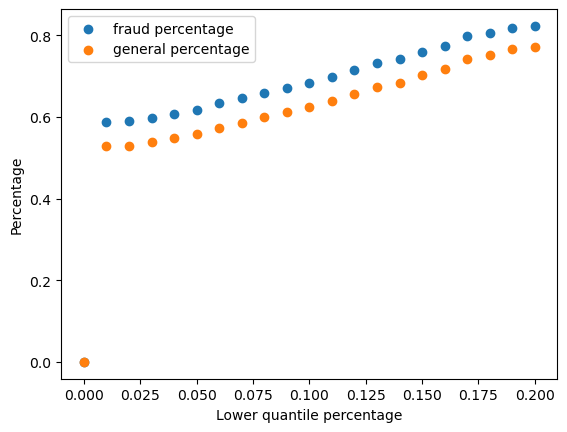

In [79]:
plt.figure()
plt.scatter(np.linspace(0,0.2,21),perc_outside_fraud,label='fraud percentage')
plt.scatter(np.linspace(0,0.2,21),perc_outside_general,label='general percentage')
plt.xlabel('Lower quantile percentage')
plt.ylabel('Percentage')
plt.legend()

plt.show()

In [83]:
time_features = JPfraud[['Time_step','Label','seconds_in_day','outside_time_bene_range','outside_time_sender_range']]
time_features

In [85]:
def label_time_range(seconds):
    return int(seconds/3600) + 1

In [87]:
# transaction_hour: hour of transaction within a day
time_features['transaction_hour'] = time_features.seconds_in_day.apply(label_time_range)
time_features

In [ ]:
(time_features[time_features.Label == 1].outside_time_bene_range.sum() +
time_features[time_features.Label == 1].outside_time_sender_range.sum())/len(time_features[time_features.Label == 1])

In [ ]:
(time_features.outside_time_bene_range.sum() + time_features.outside_time_sender_range.sum())/len(time_features)

In [ ]:
time_features.to_csv('data/time_features.csv')

In [ ]:
time_features[time_features.Label == 1].groupby('transaction_hour').Label.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of frauds')
plt.ylim([0,700])
plt.show()

In [ ]:
time_features[time_features.outside_time_bene_range == 1].groupby('transaction_hour').outside_time_bene_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of outside time range IN transactions')
plt.ylim([0,14000])
plt.show()

In [ ]:
time_features[time_features.outside_time_sender_range == 1].groupby('trans_hour').outside_time_sender_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of outside time range OUT transactions')
plt.ylim([0,14000])
plt.show()

In [ ]:
time_features[((time_features.outside_time_sender_range == 1) & (time_features.Label == 1))].groupby(
    'trans_hour').outside_time_sender_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of fraudulent outside time range OUT transactions')
#plt.ylim([0,14000])
plt.show()

In [ ]:
time_features[((time_features.outside_sender_bene_range == 1) & (time_features.Label == 1))].groupby(
    'trans_hour').outside_time_bene_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of fraudulent outside time range IN transactions')
#plt.ylim([0,14000])
plt.show()

In [ ]:
JPfraud.loc[JPfraud.Sender_Id == sendIDs[9]].USD_amount.agg('describe')[['std','min','25%','50%','mean','75%','max']].values

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
#sender_fraud_stat_amounts = JPfraud.loc[JPfraud.Label == 1].groupby(
#    'Sender_Id').USD_amount.agg('describe')[['std','min','25%','50%','mean','75%','max']].reset_index()
#sender_fraud_stat_amounts

In [ ]:
JPfraud[JPfraud.Bene_Id == 'CLIENT-725719'].outside_time_out_range.sum()

In [ ]:
JPfraud[JPfraud.Bene_Id == 'CLIENT-725719'].Label.sum()

In [ ]:
JPfraud[JPfraud.Sender_Account == 'ACCOUNT-9825']